In [1]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2
import tensorflow as tf 

from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import StratifiedShuffleSplit

random.seed(999)

In [2]:
IMAGES_PATH = "covers-jpg/"

In [3]:
image_files = list(os.listdir(IMAGES_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5810


The image size is: (170, 255)


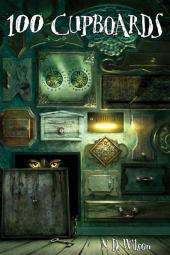

In [4]:
sample = Image.open('covers-jpg/10_100-cupboards-the-100-cupboards-book-1.jpg') 
print("The image size is: {}".format(sample.size))
sample

In [5]:
covers = [cv2.imread(IMAGES_PATH+image) for image in image_files]
height = [cover.shape[0] for cover in covers]
width = [cover.shape[1] for cover in covers]
channels = [cover.shape[2] for cover in covers]

In [6]:
print("The average width of the covers is: {:.3f}".format(sum(width)/len(width)))
print("The average height of the covers is: {:.3f}".format(sum(height)/len(width)))
print("All {:d} images are in color".format(sum(map(lambda x : x == 3, channels))))

The average width of the covers is: 169.988
The average height of the covers is: 240.513
All 5810 images are in color


In [7]:
filenames = os.listdir('covers-jpg')

titles = [filename for filename in filenames]
ratings = [filename.split('_')[0] for filename in filenames]


In [8]:
df = pd.DataFrame({
    'title': titles,
    'rating': ratings
})

In [9]:
df['rating'] = df['rating'].astype('int')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5810 entries, 0 to 5809
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5810 non-null   object
 1   rating  5810 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.9+ KB


In [11]:
df.head()

,title,rating
0,10_96-miles.jpg,10
1,13_dance-of-thieves-book-1.jpg,13
2,4_my-mom-is-trying-to-ruin-my-life.jpg,4
3,13_mortal-danger-the-immortal-game-book-1.jpg,13
4,11_ways-to-live-forever.jpg,11


In [12]:
IMAGE_WIDTH=170
IMAGE_HEIGHT=240
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

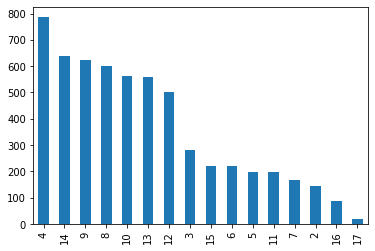

In [13]:
df['rating'].value_counts().plot.bar();

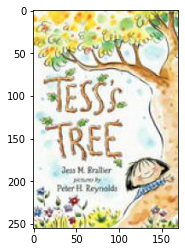

In [14]:
sample = random.choice(filenames)
image = load_img(IMAGES_PATH+sample)
plt.imshow(image)

## Build a Model

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 168, 238, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 168, 238, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 119, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 84, 119, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 117, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 82, 117, 64)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 58, 64)        0

### Callbacks

In [16]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mae', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

### Split the Data

In [17]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=999)

In [18]:
for train_df, validate_df in split.split(df, df['rating']):
    train_df = df.loc[train_df]
    validate_df = df.loc[validate_df]

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4648 entries, 0 to 4647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   4648 non-null   object
 1   rating  4648 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 72.8+ KB


In [20]:
train_df['rating'].value_counts() / len(train_df)

4     0.135542
14    0.109725
9     0.107143
8     0.103055
10    0.096601
13    0.096170
12    0.086489
3     0.048623
15    0.037866
6     0.037651
11    0.034208
5     0.034208
7     0.029045
2     0.025172
16    0.015275
17    0.003227
Name: rating, dtype: float64

In [21]:
validate_df['rating'].value_counts() / len(validate_df)

4     0.135112
14    0.110155
9     0.107573
8     0.103270
13    0.096386
10    0.096386
12    0.086919
3     0.048193
15    0.037866
6     0.037866
5     0.034423
11    0.033563
7     0.029260
2     0.024957
16    0.015491
17    0.002582
Name: rating, dtype: float64

In [22]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16

## Training Generator

In [23]:
train_df.head()

,title,rating
0,11_the-ruins-of-gorlan-the-rangers-apprentice-...,11
1,14_dividing-eden-dividing-eden-book-1.jpg,14
2,7_zita-the-spacegirl.jpg,7
3,8_countdown-zero-codename-conspiracy-series-bo...,8
4,9_sipping-spiders-through-a-straw-campfire-son...,9


In [24]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

In [25]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory=IMAGES_PATH, 
    x_col='title',
    y_col='rating',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size
)

Found 4648 validated image filenames.


## Validation Generator

In [26]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=IMAGES_PATH, 
    x_col='title',
    y_col='rating',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size
)

Found 1162 validated image filenames.


## See how our generator work

In [27]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    directory=IMAGES_PATH, 
    x_col='title',
    y_col='rating',
    target_size=IMAGE_SIZE,
    class_mode='raw'
)

Found 1 validated image filenames.


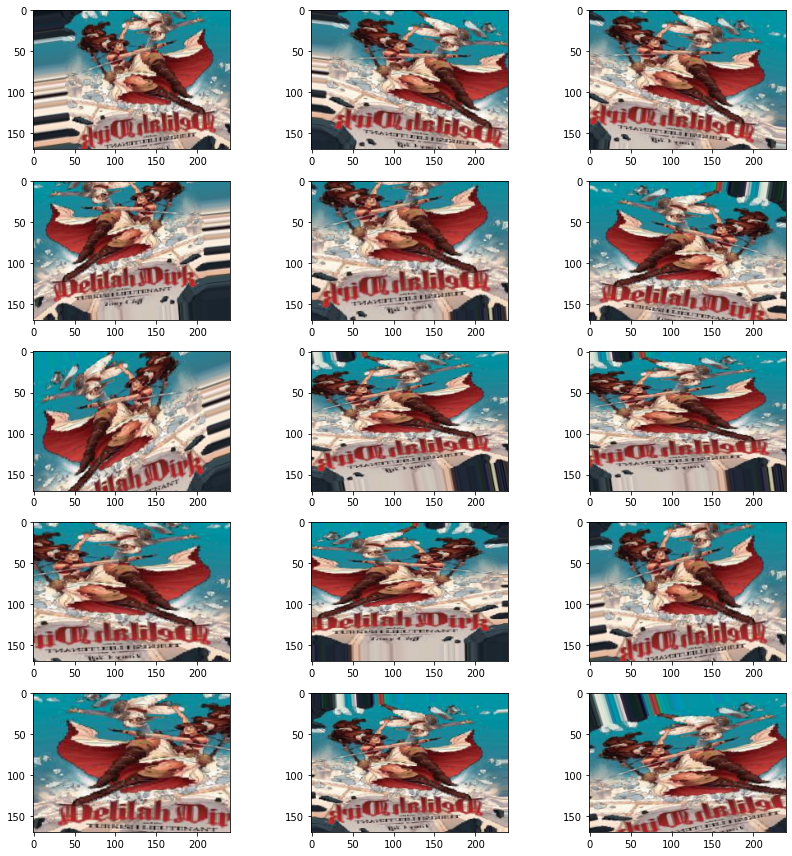

In [28]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.savefig("reports/generated_image.png")
plt.show()

# Fit the Model

In [29]:
history = model.fit(
    train_generator, 
    epochs= 50,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
290/290 [==============================] - 293s 1s/step - loss: 35.8373 - mae: 4.7540 - val_loss: 18.0712 - val_mae: 3.5861
Epoch 2/50
290/290 [==============================] - 282s 972ms/step - loss: 23.3603 - mae: 3.8015 - val_loss: 22.2554 - val_mae: 3.6422
Epoch 3/50
290/290 [==============================] - 309s 1s/step - loss: 20.8936 - mae: 3.6175 - val_loss: 13.5998 - val_mae: 2.9801
Epoch 4/50
290/290 [==============================] - 303s 1s/step - loss: 16.1360 - mae: 3.2307 - val_loss: 20.3393 - val_mae: 3.4548
Epoch 5/50
290/290 [==============================] - 287s 989ms/step - loss: 14.9911 - mae: 3.1178 - val_loss: 12.0984 - val_mae: 2.8147
Epoch 6/50
290/290 [==============================] - 361s 1s/step - loss: 14.2739 - mae: 3.0497 - val_loss: 16.3368 - val_mae: 3.2379
Epoch 7/50
290/290 [==============================] - 320s 1s/step - loss: 13.7102 - mae: 2.9940 - val_loss: 12.3405 - val_mae: 2.8734
Epoch 8/50
290/290 [=============================

In [30]:
model.save_weights("cover_model2.h5")

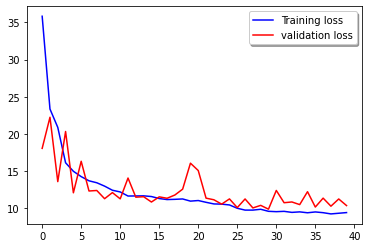

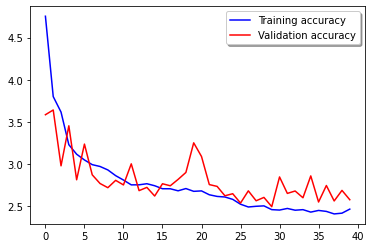

In [31]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
#plt.savefig('reports/cover_training.png')
plt.show()

plt.plot(history.history['mae'], color='b', label="Training accuracy")
plt.plot(history.history['val_mae'], color='r',label="Validation accuracy")
plt.legend(loc='best', shadow=True)
#plt.savefig('reports/cover_mae.png')
plt.show()